In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import A3TGCN2

from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric.datasets import Planetoid
from torch_geometric_temporal.dataset import METRLADatasetLoader
import pandas as pd
import sys
# GPU support
DEVICE = torch.device('cuda:0') # cuda
shuffle=True
batch_size = 32

device = torch.device(
    "cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [78]:
import os.path as osp
path = osp.join(osp.dirname('/mnt/d1/siji/projects/timeseries/'),
                    '..', 'data', 'Planetoid')
DATA_SET='Cora'
# DATA_SET='PubMed'
# DATA_SET='CiteSeer'
SPLIT='full'
# SPLIT='random'
dataset = Planetoid(path, name=DATA_SET, split=SPLIT)
# dataset = Planetoid(path, name='Cora', split=SPLIT)
data = dataset[0]

In [79]:

# number edges 
edges = data.edge_index.t().tolist()
print('edges', len(edges))
# print node
print('nodes', len(data.x))
# features per node
print('features per node', len(data.x[0]))
# how many train nodes?
print('train nodes', sum(data.train_mask))
print('val nodes', sum(data.val_mask))
print('test nodes', sum(data.test_mask))
# how many labels?
print('labels', len(data.y.unique()))


edges 10556
nodes 2708
features per node 1433
train nodes tensor(1208)
val nodes tensor(500)
test nodes tensor(1000)
labels 7


Text(0.5, 1.0, 'sigmoid(X@X.T) histogram')

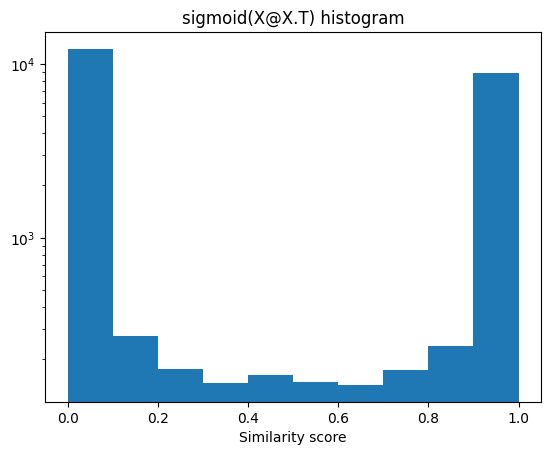

In [22]:
from sklearn import datasets
iris=datasets.load_iris()
x=iris.data
y=iris.target
x=torch.tensor(x, dtype=torch.float)
decode = x.to(device)
# random mask 20% of the nodes
mask = torch.rand(decode.size(0)) < 10

# decode = decode[mask]
decode = (decode@decode.T)
adj = torch.sigmoid(decode-decode.mean())
# adj=decode
# print(decode.mean())
plt.hist(adj.flatten().detach().cpu().numpy(), bins=10)
#     # use log on y axis
plt.yscale('log')
plt.xlabel('Similarity score')
plt.title('sigmoid(X@X.T) histogram')

Text(0.5, 1.0, 'sigmoid(X@X.T) histogram')

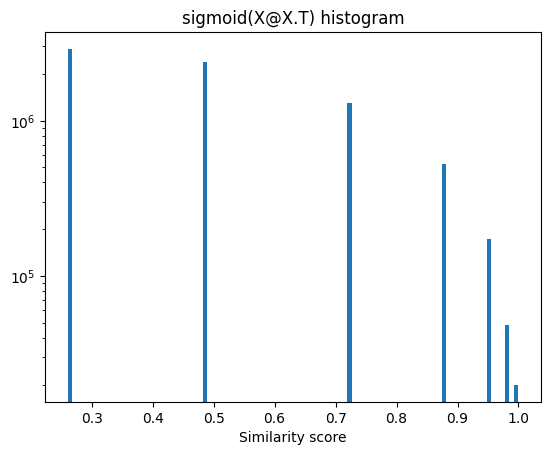

In [25]:
decode = data.x.to(device)
# random mask 20% of the nodes
mask = torch.rand(decode.size(0)) < 1

# decode = decode[mask]
decode = (decode@decode.T)
adj = torch.sigmoid(decode-decode.mean())
# adj=decode
plt.hist(adj.flatten().detach().cpu().numpy(), bins=100)
#     # use log on y axis
plt.yscale('log')
plt.xlabel('Similarity score')
plt.title('sigmoid(X@X.T) histogram')

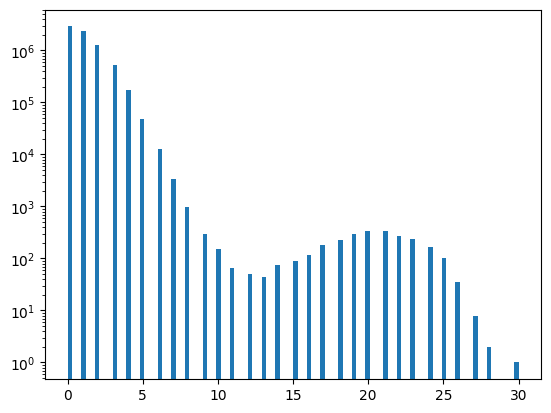

In [6]:

plt.hist(decode.flatten().detach().cpu().numpy(), bins=100)
#     # use log on y axis
plt.yscale('log')

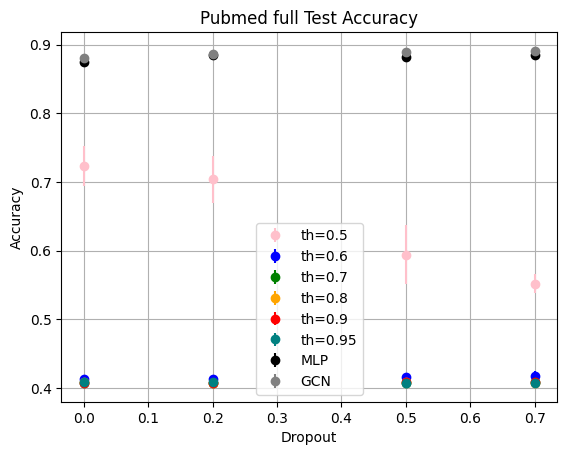

In [97]:

hidden_dim=128
th2=1
# DATA_SET='Cora'
# DATA_SET='CiteSeer'
DATA_SET='Pubmed'
SPLIT='public'
SPLIT='full'
# SPLIT='random'

for th1 in [0.5,0.6,0.7, 0.8, 0.9, 0.95]: 
    for drop in [0, 0.2, 0.5, 0.7]:
        
        file_name=f'./results/{DATA_SET}_{SPLIT}_hs_{hidden_dim}_drop_{drop}_th1_{th1}_th2_{th2}.csv'
        df=pd.read_csv(file_name)
        train_acc=df['train_acc'].mean()
        test_acc=df['test_acc'].mean()
        train_acc_std=df['train_acc'].std()
        test_acc_std=df['test_acc'].std()
        if th1==0.5:
            handle0=plt.errorbar(drop, test_acc, yerr=test_acc_std, fmt='o', color='pink')
        if th1==0.6:
            handle1 =plt.errorbar(drop, test_acc, yerr=test_acc_std, fmt='o', color='blue')
        elif th1==0.7:
            handle2 = plt.errorbar(drop, test_acc, yerr=test_acc_std, fmt='o', color='green')
        elif th1==0.8:
            handle3 =plt.errorbar(drop, test_acc, yerr=test_acc_std, fmt='o', color='orange')
        elif th1==0.9:
            handle4 =plt.errorbar(drop, test_acc, yerr=test_acc_std, fmt='o', color='red')
        elif th1==0.95:
            handle5 =plt.errorbar(drop, test_acc, yerr=test_acc_std, fmt='o', color='teal')
        
for drop in [0, 0.2, 0.5, 0.7]:
    file_name=f'./results/{DATA_SET}_{SPLIT}_hs_{hidden_dim}_drop_{drop}_MLP.csv'
    df=pd.read_csv(file_name)
    train_acc=df['train_acc'].mean()
    test_acc=df['test_acc'].mean()
    train_acc_std=df['train_acc'].std()
    test_acc_std=df['test_acc'].std()
    
    handle6 =plt.errorbar(drop, test_acc, yerr=test_acc_std, fmt='o', color='black')
for drop in [0, 0.2, 0.5, 0.7]:
    file_name=f'./results/{DATA_SET}_{SPLIT}_hs_{hidden_dim}_drop_{drop}_GCN.csv'
    df=pd.read_csv(file_name)
    train_acc=df['train_acc'].mean()
    test_acc=df['test_acc'].mean()
    train_acc_std=df['train_acc'].std()
    test_acc_std=df['test_acc'].std()
    
    handle7 =plt.errorbar(drop, test_acc, yerr=test_acc_std, fmt='o', color='grey')

plt.xlabel('Dropout')
plt.ylabel('Accuracy')
# add legend for the th1 with blue color
plt.legend([handle0, handle1, handle2, handle3, handle4, handle5, handle6, handle7], 
           ['th=0.5','th=0.6', 'th=0.7', 'th=0.8', 'th=0.9','th=0.95', 'MLP','GCN'])
plt.title(f'{DATA_SET} {SPLIT} Test Accuracy')
plt.grid()
plt.savefig(f'./figures/{DATA_SET}_{SPLIT}_test_accuracy.png')

In [98]:
DATA_SET='Pubmed'
SPLIT='public'
# SPLIT='full'
hidden_dim=128
th2=1

for th1 in [0.75,0.8, 0.85]: # for Pubmed
    for drop in [0, 0.2, 0.5, 0.7]:
        
        file_name=f'./results/{DATA_SET}_{SPLIT}_hs_{hidden_dim}_drop_{drop}_th1_{th1}_th2_{th2}.csv'
        df=pd.read_csv(file_name)
        train_acc=df['train_acc'].mean()
        test_acc=df['test_acc'].mean()
        train_acc_std=df['train_acc'].std()
        test_acc_std=df['test_acc'].std()
      
        if th1==0.75:
            handle1 =plt.errorbar(drop, test_acc, yerr=test_acc_std, fmt='o', color='blue')
        elif th1==0.8:
            handle2 = plt.errorbar(drop, test_acc, yerr=test_acc_std, fmt='o', color='green')
        elif th1==0.85:
            handle3 =plt.errorbar(drop, test_acc, yerr=test_acc_std, fmt='o', color='orange')
        
for drop in [0, 0.2, 0.5, 0.7]:
    file_name=f'./results/{DATA_SET}_{SPLIT}_hs_{hidden_dim}_drop_{drop}_MLP.csv'
    df=pd.read_csv(file_name)
    train_acc=df['train_acc'].mean()
    test_acc=df['test_acc'].mean()
    train_acc_std=df['train_acc'].std()
    test_acc_std=df['test_acc'].std()
    
    handle5 =plt.errorbar(drop, test_acc, yerr=test_acc_std, fmt='o', color='black')

plt.xlabel('Dropout')
plt.ylabel('Accuracy')
# add legend for the th1 with blue color
plt.legend([handle1, handle2, handle3, handle5], ['th=0.75', 'th=0.8', 'th=0.85', 'MLP'])
plt.title(f'{DATA_SET} {SPLIT} Test Accuracy')
plt.savefig(f'./figures/{DATA_SET}_{SPLIT}_test_accuracy.png')

FileNotFoundError: [Errno 2] No such file or directory: './results/Pubmed_public_hs_128_drop_0_th1_0.75_th2_1.csv'

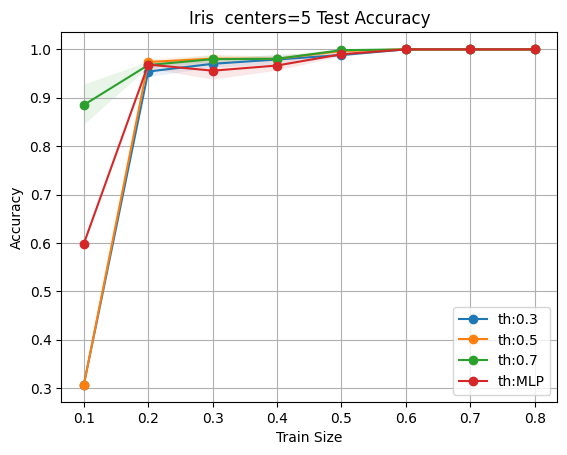

In [118]:

hidden_dim=32
th2=1
DATA_SET='Iris'
num_centroids=5
drop=0.2
train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
th1s=[0.3, 0.5, 0.7,  'MLP']
# th1s=[  0.5,   'MLP']
all_results_mean={}
all_results_std={}
# for train_size in [0.1]:
for train_size in train_sizes:
    all_results_mean[train_size]=[]
    all_results_std[train_size]=[]
    for th1 in th1s[:-1]: # for Iris        
        file_name=f'./results/{DATA_SET}_{train_size}_hs_{hidden_dim}_drop_{drop}_th1_{th1}_th2_{th2}_centroids_{num_centroids}.csv'
        df=pd.read_csv(file_name)
        train_acc=df['train_acc'].mean()
        test_acc=df['test_acc'].mean()
        train_acc_std=df['train_acc'].std()
        test_acc_std=df['test_acc'].std()
        all_results_mean[train_size].append(test_acc)
        all_results_std[train_size].append(test_acc_std)
    # for MLP
    file_name=f'./results/{DATA_SET}_{train_size}_hs_{hidden_dim}_drop_{drop}_MLP.csv'
    df=pd.read_csv(file_name)
    train_acc=df['train_acc'].mean()
    test_acc=df['test_acc'].mean()
    train_acc_std=df['train_acc'].std()
    test_acc_std=df['test_acc'].std()
    all_results_mean[train_size].append(test_acc)
    all_results_std[train_size].append(test_acc_std)
     

all_results_mean=pd.DataFrame(all_results_mean,index=th1s)
all_results_std=pd.DataFrame(all_results_std,index=th1s)

fig, ax=plt.subplots()
for th in th1s:
    x=all_results_mean.columns
    mean=all_results_mean.loc[th]
    lower=all_results_mean.loc[th]-all_results_std.loc[th]/2.
    upper=all_results_mean.loc[th]+all_results_std.loc[th]/2.
    ax.plot(x, mean, 'o-',label=f'th:{th}', )
    ax.fill_between(x, lower,upper, alpha=0.1)
plt.xlabel('Train Size')
plt.ylabel('Accuracy')
plt.legend()
# add legend for the th1 with blue color
# plt.legend([handle0, handle1, handle2, handle3, handle5], ['th=0.3','th=0.5', 'th=0.7', 'th=0.9', 'MLP'])
plt.title(f'{DATA_SET}  centers={num_centroids} Test Accuracy')
plt.grid()
plt.savefig(f'./figures/{DATA_SET}_{num_centroids}_test_accuracy.png')

In [99]:
# get pred result
# load tensor from fn.pt file
pred_gcn=torch.load(f'./results/{DATA_SET}_pred_GCN.pt')
pred_mlp=torch.load(f'./results/{DATA_SET}_pred_MLP.pt')
pred_infer=torch.load(f'./results/{DATA_SET}_pred_Infer.pt')

In [103]:
pred_gcn[data.test_mask].argmax(dim=-1)[:10]

tensor([1, 2, 2, 2, 2, 0, 2, 2, 2, 2])

In [105]:
pred_mlp[data.test_mask].argmax(dim=-1)[:10]

tensor([0, 0, 0, 2, 2, 0, 2, 2, 1, 5])

In [104]:
pred_infer[data.test_mask].argmax(dim=-1)[:10]

tensor([0, 5, 0, 2, 2, 0, 2, 2, 3, 2])

In [106]:
data.y[data.test_mask][:10]

tensor([3, 2, 2, 2, 2, 0, 2, 2, 2, 2])